# Обучение модели RetinaNet

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! cd /content/drive/MyDrive/retina_train
!pwd

/content


In [3]:
!pwd

/content


In [4]:
import sys
sys.path.append("/content/drive/MyDrive/retina_train")

In [5]:
import os
os.chdir("/content/drive/MyDrive/retina_train")
os.getcwd()

'/content/drive/MyDrive/retina_train'

In [6]:
!pip install torchmetrics

In [7]:
from config import (
    DEVICE,
    NUM_CLASSES,
    NUM_EPOCHS,
    OUT_DIR,
    VISUALIZE_TRANSFORMED_IMAGES,
    NUM_WORKERS,
    RESIZE_TO,
    VALID_DIR,
    TRAIN_DIR,
)
from model import create_model
from custom_utils import Averager, SaveBestModel, save_model, save_loss_plot, save_mAP
from tqdm.auto import tqdm
from my_datasets import create_train_dataset, create_valid_dataset, create_train_loader, create_valid_loader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import torch
import matplotlib.pyplot as plt
import time
import os

plt.style.use("ggplot")

In [8]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [9]:
# Function for running training iterations.
def train(train_data_loader, model):
    print("Training")
    model.train()

    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value


# Function for running validation iterations.
def validate(valid_data_loader, model):
    print("Validating")
    model.eval()

    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict["boxes"] = targets[i]["boxes"].detach().cpu()
            true_dict["labels"] = targets[i]["labels"].detach().cpu()
            preds_dict["boxes"] = outputs[i]["boxes"].detach().cpu()
            preds_dict["scores"] = outputs[i]["scores"].detach().cpu()
            preds_dict["labels"] = outputs[i]["labels"].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)
        #####################################

    metric.reset()
    metric.update(preds, target)
    metric_summary = metric.compute()
    return metric_summary

In [10]:
os.makedirs("outputs", exist_ok=True)
train_dataset = create_train_dataset(TRAIN_DIR)
valid_dataset = create_valid_dataset(VALID_DIR)
train_loader = create_train_loader(train_dataset, NUM_WORKERS)
valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

# Initialize the model and move to the computation device.
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",  # we want to maximize mAP
    factor=0.1,  # reduce LR by this factor
    patience=8,  # wait 3 epochs with no improvement
    threshold=0.005,  # how much improvement is considered significant
    cooldown=1,
)

# To monitor training loss
train_loss_hist = Averager()
# To store training loss and mAP values.
train_loss_list = []
map_50_list = []
map_list = []

# Mame to save the trained model with.
MODEL_NAME = "model"

# Whether to show transformed images from data loader or not.
if VISUALIZE_TRANSFORMED_IMAGES:
    from custom_utils import show_tranformed_image

    show_tranformed_image(train_loader)

# To save best model.
save_best_model = SaveBestModel()

metric = MeanAveragePrecision()
metric.warn_on_many_detections = False

/usr/local/lib/python3.11/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Number of training samples: 468
Number of validation samples: 144

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps


EPOCH 1 of 5
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #1 train loss: 1.635
Epoch #1 mAP: 0.058
Took 5.575 minutes for epoch 1

BEST VALIDATION mAP: 0.05803321301937103
SAVING BEST MODEL FOR EPOCH: 1

SAVING PLOTS COMPLETE...
SAVING mAP PLOTS COMPLETE...
Current LR: [0.01]

EPOCH 2 of 5
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #2 train loss: 0.853
Epoch #2 mAP: 0.122
Took 5.086 minutes for epoch 2

BEST VALIDATION mAP: 0.1224035769701004
SAVING BEST MODEL FOR EPOCH: 2

SAVING PLOTS COMPLETE...
SAVING mAP PLOTS COMPLETE...
Current LR: [0.01]

EPOCH 3 of 5
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #3 train loss: 0.787
Epoch #3 mAP: 0.150
Took 4.143 minutes for epoch 3

BEST VALIDATION mAP: 0.1496417373418808
SAVING BEST MODEL FOR EPOCH: 3

SAVING PLOTS COMPLETE...
SAVING mAP PLOTS COMPLETE...
Current LR: [0.01]

EPOCH 4 of 5
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

RuntimeError: DataLoader worker (pid 8699) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.

RuntimeError: DataLoader worker (pid 8707) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.

<Figure size 1000x700 with 1 Axes>

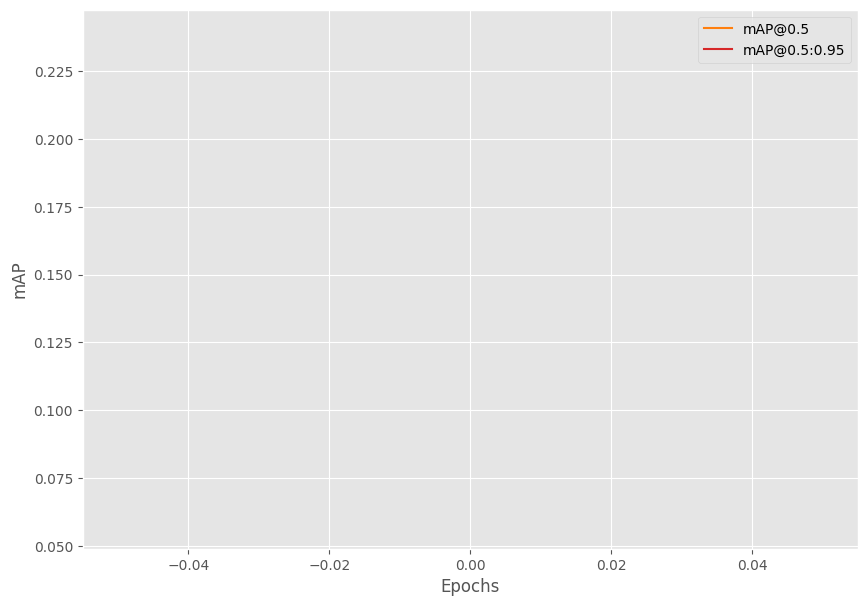

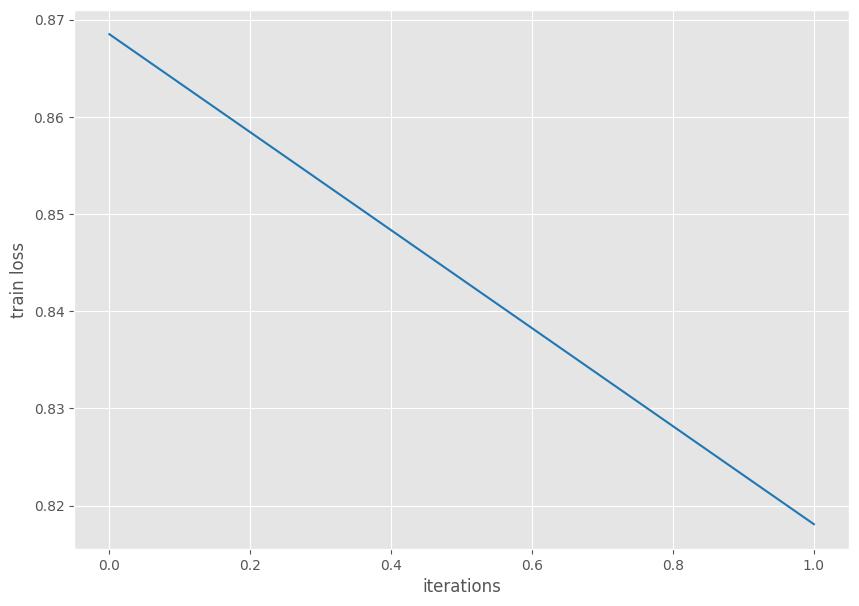

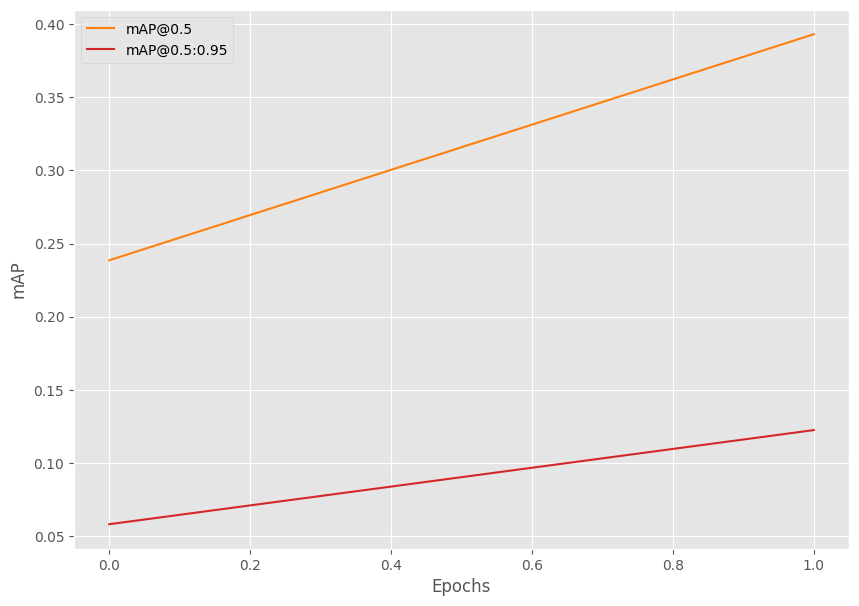

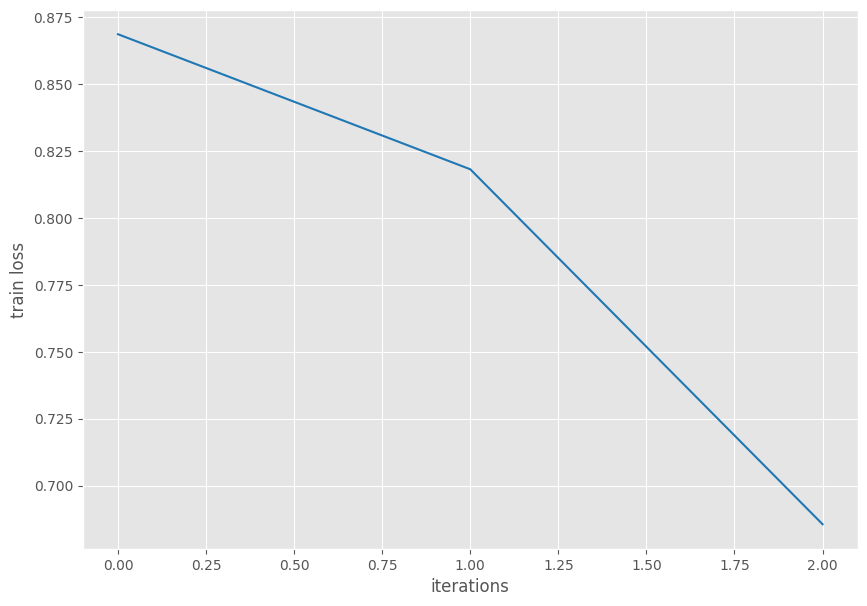

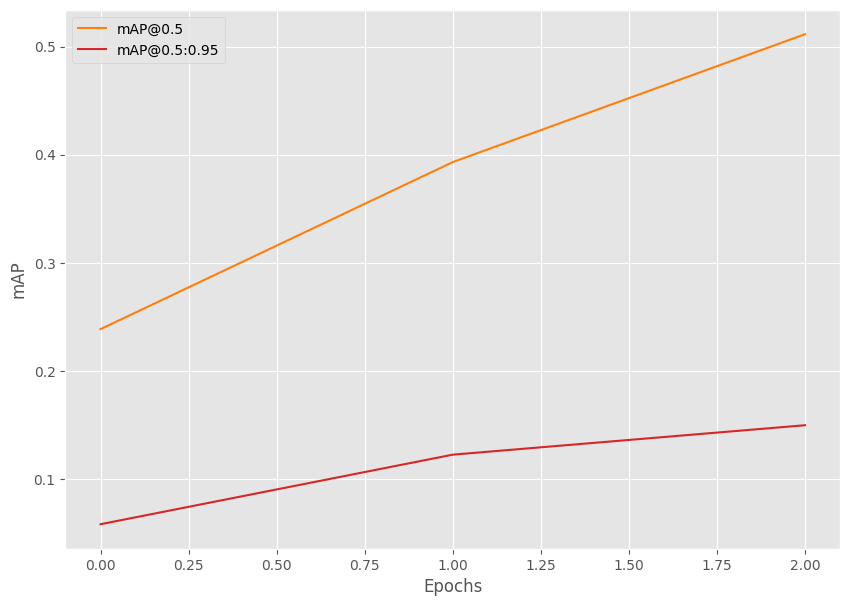

In [11]:
NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
  print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

  # Reset the training loss histories for the current epoch.
  train_loss_hist.reset()

  # Start timer and carry out training and validation.
  start = time.time()
  train_loss = train(train_loader, model)
  metric_summary = validate(valid_loader, model)
  current_map_05_95 = float(metric_summary["map"])
  current_map_05 = float(metric_summary["map_50"])
  print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
  print(f"Epoch #{epoch+1} mAP: {metric_summary['map']:.3f}")
  end = time.time()
  print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

  train_loss_list.append(train_loss)
  map_50_list.append(metric_summary["map_50"])
  map_list.append(metric_summary["map"])

  # save the best model till now.
  save_best_model(model, float(metric_summary["map"]), epoch, "outputs")
  # Save the current epoch model.
  save_model(epoch, model, optimizer)

  # Save loss plot.
  save_loss_plot(OUT_DIR, train_loss_list)

  # Save mAP plot.
  save_mAP(OUT_DIR, map_50_list, map_list)
  scheduler.step(current_map_05_95)
  print("Current LR:", scheduler.get_last_lr())